### Data Cleaning

In [88]:
import pandas as pd
file_path = r'D:\dsci\CAHOOTS\Data\newcaddata.csv'
CAD_data = pd.read_csv(file_path)

C:\Users\Nathan Burton\AppData\Local\Temp\ipykernel_4400\374747993.py:3: DtypeWarning: Columns (4,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  CAD_data = pd.read_csv(file_path)


In [89]:
CAD_data

,yr,calltime,inci_id,parent_id,case_id,is_self,is_eug,callsource,nature,closecode,...,arrv,Lat,long,beat,priority,parent_call,primeunit,units_dispd,units_arrived,neighborhood
0,2014,2014-01-22T20:02:42.000,14016222,14016222,NaN,0,1,PHONE,FRAUD,NaN,...,0,NaN,NaN,EP05,9,NaN,NaN,0,0,NaN
1,2014,2014-02-09T18:57:39.000,14031723,14031723,NaN,0,1,PHONE,ASSIST PUBLIC- POLICE,NaN,...,0,NaN,NaN,EP02,5,NaN,NaN,0,0,NaN
2,2014,2014-02-22T11:21:27.000,14041552,14041552,1403118.0,0,1,PHONE,THEFT FROM VEHICLE,NaN,...,0,NaN,NaN,EP02,9,NaN,NaN,0,0,NaN
3,2014,2014-03-18T15:29:01.000,14059872,14059872,NaN,1,1,SELF,TRAFFIC STOP,NaN,...,1,NaN,NaN,EP06,6,NaN,_1M14,2,2,NaN
4,2014,2014-06-24T04:00:00.000,14137164,14137164,NaN,0,1,PHONE,WATER PROBLEM,NaN,...,0,NaN,NaN,EP02,P,NaN,NaN,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2020,2020-11-04T17:16:39.000,20279067,20279067,2018406.0,0,1,PHONE,ROBBERY,REPT,...,1,44.05007553,-123.0843887,EP07,4,NaN,_3E72,1,1,NaN
1048571,2020,2020-11-05T11:18:43.000,20279645,20279645,2018448.0,0,1,PHONE,UNAUTHORIZED USE OF VEHICLE,REPT,...,1,44.05197144,-123.1167144,EP05,4,NaN,_1W78,1,1,NaN
1048572,2020,2020-11-05T07:48:14.000,20279498,20279498,2018428.0,0,1,RPTO,THEFT FROM VEHICLE,REPT,...,0,NaN,NaN,EP02,P,NaN,_1W77,0,0,NaN
1048573,2020,2020-11-05T09:23:38.000,20279562,20279562,2018445.0,0,1,PHONE,LOCATION STOLEN VEHICLE,REPT,...,1,44.07762146,-123.1491241,EP05,3,NaN,_1E51,2,1,NaN


In [90]:
CAD_data = CAD_data.drop(columns=['Lat', 'long', 'beat', 'neighborhood', 'secs_to_disp','secs_to_arrv', 'secs_to_close', 'closecode', 'is_eug', 'is_self'])
CAD_data

,yr,calltime,inci_id,parent_id,case_id,callsource,nature,closed_as,disp,arrv,priority,parent_call,primeunit,units_dispd,units_arrived
0,2014,2014-01-22T20:02:42.000,14016222,14016222,NaN,PHONE,FRAUD,NaN,0,0,9,NaN,NaN,0,0
1,2014,2014-02-09T18:57:39.000,14031723,14031723,NaN,PHONE,ASSIST PUBLIC- POLICE,NaN,0,0,5,NaN,NaN,0,0
2,2014,2014-02-22T11:21:27.000,14041552,14041552,1403118.0,PHONE,THEFT FROM VEHICLE,NaN,0,0,9,NaN,NaN,0,0
3,2014,2014-03-18T15:29:01.000,14059872,14059872,NaN,SELF,TRAFFIC STOP,NaN,1,1,6,NaN,_1M14,2,2
4,2014,2014-06-24T04:00:00.000,14137164,14137164,NaN,PHONE,WATER PROBLEM,NaN,0,0,P,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2020,2020-11-04T17:16:39.000,20279067,20279067,2018406.0,PHONE,ROBBERY,REPORT TAKEN,1,1,4,NaN,_3E72,1,1
1048571,2020,2020-11-05T11:18:43.000,20279645,20279645,2018448.0,PHONE,UNAUTHORIZED USE OF VEHICLE,REPORT TAKEN,1,1,4,NaN,_1W78,1,1
1048572,2020,2020-11-05T07:48:14.000,20279498,20279498,2018428.0,RPTO,THEFT FROM VEHICLE,REPORT TAKEN,0,0,P,NaN,_1W77,0,0
1048573,2020,2020-11-05T09:23:38.000,20279562,20279562,2018445.0,PHONE,LOCATION STOLEN VEHICLE,REPORT TAKEN,1,1,3,NaN,_1E51,2,1


In [91]:
cahoots_identifiers = r"1J77\s*|3J79\s*|3J78\s*|3J77\s*|4J79\s*|3J81\s*|3J76\s*|2J28\s*|2J29\s*|CAHOOT\s*|CAHOT\s*|CAHO\s*"
CAD_data["primeunit"] = CAD_data["primeunit"].replace(cahoots_identifiers, 'CAHOOT', regex=True)
CAD_data["parent_call"] = CAD_data["parent_call"].replace(cahoots_identifiers, 'CAHOOT', regex=True)

# Create an identifier for Cahoots involvement 
CAD_data['Cahoots_related'] = ((CAD_data['primeunit'] == '_CAHOOT') | (CAD_data['parent_call'] == '_CAHOOT')).astype(int)
CAD_data["calltime"] = pd.to_datetime(CAD_data['calltime'], errors='coerce')

CAD_data

,yr,calltime,inci_id,parent_id,case_id,callsource,nature,closed_as,disp,arrv,priority,parent_call,primeunit,units_dispd,units_arrived,Cahoots_related
0,2014,2014-01-22 20:02:42,14016222,14016222,NaN,PHONE,FRAUD,NaN,0,0,9,NaN,NaN,0,0,0
1,2014,2014-02-09 18:57:39,14031723,14031723,NaN,PHONE,ASSIST PUBLIC- POLICE,NaN,0,0,5,NaN,NaN,0,0,0
2,2014,2014-02-22 11:21:27,14041552,14041552,1403118.0,PHONE,THEFT FROM VEHICLE,NaN,0,0,9,NaN,NaN,0,0,0
3,2014,2014-03-18 15:29:01,14059872,14059872,NaN,SELF,TRAFFIC STOP,NaN,1,1,6,NaN,_1M14,2,2,0
4,2014,2014-06-24 04:00:00,14137164,14137164,NaN,PHONE,WATER PROBLEM,NaN,0,0,P,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2020,2020-11-04 17:16:39,20279067,20279067,2018406.0,PHONE,ROBBERY,REPORT TAKEN,1,1,4,NaN,_3E72,1,1,0
1048571,2020,2020-11-05 11:18:43,20279645,20279645,2018448.0,PHONE,UNAUTHORIZED USE OF VEHICLE,REPORT TAKEN,1,1,4,NaN,_1W78,1,1,0
1048572,2020,2020-11-05 07:48:14,20279498,20279498,2018428.0,RPTO,THEFT FROM VEHICLE,REPORT TAKEN,0,0,P,NaN,_1W77,0,0,0
1048573,2020,2020-11-05 09:23:38,20279562,20279562,2018445.0,PHONE,LOCATION STOLEN VEHICLE,REPORT TAKEN,1,1,3,NaN,_1E51,2,1,0


In [92]:
CAD_data["Cahoots_related"].value_counts().head(50)

Cahoots_related
0    951086
1     97489
Name: count, dtype: int64

In [93]:
def filter_df_by_time(df, start_time=None, end_time=None, time_column='calltime'):
    """
    Filters the dataframe based on the time range specified by the user

    Parameters:
    df to filter
    start_time (str)
    end_time (str)
    time_column (str): The name of the column containing datetime values

    """
    df.loc[:, time_column] = pd.to_datetime(df[time_column])

    if start_time:
        if len(start_time) == 4:  # if only a year is given
            start_time = pd.to_datetime(f"{start_time}-01-01")
    else:
        start_time = df[time_column].min() 

    if end_time:
        if len(end_time) == 4:  
            end_time = pd.to_datetime(f"{end_time}-12-31 23:59:59")
    else:
        end_time = df[time_column].max()  

    filtered_df = df[(df[time_column] >= start_time) & (df[time_column] <= end_time)]

    return filtered_df

In [94]:
CAD_data = CAD_data[~CAD_data["yr"].isin([2022, 2023])]
CAD_data = CAD_data[CAD_data["callsource"] != 'SELF']

In [252]:
def dataset_builder(data, dispatched=False, arrived=False, solo_cahoots=False, time=None):
    """
    Parameters:
    time (list of strings) [start time, end time, time_col]
    
    """
    # Apply time range if specified
    if time:
        data = filter_df_by_time(data, time[0], time[1], time[2])
    
    # Dispatched filter is based on "Unit_Dispatched_Time"
    if dispatched:
        data = data[data["disp"] == 1]
    
    # Arrived filter is based on "Call_First_Dispatched_Time"
    if arrived:
        data = data[data["arrv"] == 1]
        
    # Only Include CAHOOTS calls where no other agencies are involved
    if solo_cahoots:
        data = data[((data['primeunit'] == '_CAHOOT') & (data['units_dispd'] <=1))]
        
    return data

In [253]:
dataset_builder(CAD_data, dispatched=True, arrived=True, solo_cahoots= True, time=['2021', '2021', 'calltime'])

,yr,calltime,inci_id,parent_id,case_id,callsource,nature,closed_as,disp,arrv,priority,parent_call,primeunit,units_dispd,units_arrived,Cahoots_related
34475,2021,2021-06-07 14:14:02,21138793,21138793,NaN,PHONE,TRANSPORT,ADVISED,1,1,7,NaN,_CAHOOT,1,1,1
34853,2021,2021-05-05 11:25:13,21107719,21107719,NaN,PHONE,CHECK WELFARE,ADVISED,1,1,7,NaN,_CAHOOT,1,1,1
34880,2021,2021-05-06 19:15:19,21109176,21109176,NaN,PHONE,CHECK WELFARE,ADVISED,1,1,7,NaN,_CAHOOT,1,1,1
35140,2021,2021-09-16 19:05:42,21238673,21238671,NaN,E911,SUICIDAL SUBJECT,ADVISED,1,1,7,"{""inci_id"":""21238671"",""agency"":""MTRO"",""calltim...",_CAHOOT,1,1,1
35213,2021,2021-09-29 15:43:56,21251303,21251303,NaN,PHONE,CHECK WELFARE,ADVISED,1,1,5,NaN,_CAHOOT,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040652,2021,2021-05-07 04:21:53,21109420,21109420,NaN,W911,ASSIST PUBLIC- POLICE,QUIET ON ARRIVAL,1,1,5,NaN,_CAHOOT,1,1,1
1040788,2021,2021-04-10 13:36:11,21084727,21084727,NaN,PHONE,ASSIST PUBLIC- POLICE,QUIET ON ARRIVAL,1,1,7,NaN,_CAHOOT,1,1,1
1040797,2021,2021-01-26 23:05:34,21021358,21021358,NaN,PHONE,CHECK WELFARE,QUIET ON ARRIVAL,1,1,5,NaN,_CAHOOT,1,1,1
1040825,2021,2021-01-03 02:08:58,21001593,21001564,NaN,PHONE,ASSIST PUBLIC- POLICE,QUIET ON ARRIVAL,1,1,7,"{""inci_id"":""21001564"",""agency"":""EPD "",""calltim...",_CAHOOT,1,1,1


# Overlapping mandate

In [137]:
import numpy as np
def common_types(dataset, col):
    # Create subsets for Cahoots-related and police-handled incidents
    cahoots_related = dataset[dataset["Cahoots_related"] == 1]
    police_handled = dataset[dataset["Cahoots_related"] == 0]
    
    # Determine overlapping incident types
    cahoots_types = set(cahoots_related[col].unique())
    police_types = set(police_handled[col].unique())
    common_types = list(cahoots_types.intersection(police_types))
    
    return common_types


def prop_table(dataset):
    # Get common incident types between Cahoots and police-handled incidents
    type_list = common_types(dataset=dataset, col="nature")
    
    # Filter datasets based on these common incident types
    cahoots_related = dataset[(dataset["Cahoots_related"] == 1) & (dataset["nature"].isin(type_list))]
    police_handled = dataset[(dataset["Cahoots_related"] == 0) & (dataset["nature"].isin(type_list))]
    
    # Calculate incident counts for each type
    cahoots_counts = cahoots_related["nature"].value_counts()
    police_counts = police_handled["nature"].value_counts()
    
    # Merge the two counts on the incident types to ensure alignment
    merged_counts = cahoots_counts.to_frame(name="cahoots_count").join(police_counts.to_frame(name="police_count"), how="inner")
    
    # Calculate the proportion of incidents handled by Cahoots for each type
    merged_counts["prop_cahoots"] = merged_counts["cahoots_count"] / (merged_counts["cahoots_count"] + merged_counts["police_count"])
    
    # Create the final DataFrame and sort by the proportion
    final_df = merged_counts.reset_index().rename(columns={"index": "nature"})
    final_df = final_df.sort_values(by="prop_cahoots", ascending=False)
    
    return final_df


def simple_overlap_data(data, lower_threshold, upper_threshold):
    if lower_threshold > upper_threshold:
        raise ValueError("ERROR: Lower threshold cannot be greater than upper threshold")
    
    # Generate the proportion table
    comparison_table = prop_table(data)
    
    # Filter the table based on the thresholds
    filtered_calls_table = comparison_table[
        (comparison_table["prop_cahoots"] > lower_threshold) & 
        (comparison_table["prop_cahoots"] < upper_threshold)
    ]
    filtered_calls_list = filtered_calls_table["nature"].tolist()
    
    # Return data for incident types that fall within the thresholds
    overlap_data = data[data["nature"].isin(filtered_calls_list)]
    
    return overlap_data


def calculate_diversions(data, by_year=True):
    # Split the data into Cahoots-related and police-handled subsets
    cahoots_related = data[data["Cahoots_related"] == 1]
    police_handled = data[data["Cahoots_related"] == 0]
    
    if by_year:
        # Calculate diversions by year
        cahoots_year = cahoots_related.groupby("yr").size()
        epd_year = police_handled.groupby("yr").size()
        total_year = cahoots_year.add(epd_year, fill_value=0)
        
        # Avoid division by zero
        diversion_rate_by_year = (cahoots_year / total_year.replace(0, np.nan)) * 100
        diversion_rate_by_year = diversion_rate_by_year.fillna(0)  # Replace NaN (from division by zero) with 0
        
        # Reset index and rename columns for consistency
        diversion_rate_by_year = diversion_rate_by_year.reset_index()
        diversion_rate_by_year.columns = ['yr', 'Diversion Rate']
        
        return diversion_rate_by_year
    else:
        # Calculate overall diversion rate
        total_cases = len(cahoots_related) + len(police_handled)
        if total_cases == 0:
            diversion_rate = 0
        else:
            diversion_rate = (len(cahoots_related) / total_cases) * 100
        return diversion_rate

In [138]:
calculate_diversions((dataset_builder(CAD_data, dispatched=True, arrived=True, time=['2016', '2021', 'calltime'])))

,yr,Diversion Rate
0,2016,19.218421
1,2017,24.278346
2,2018,25.035442
3,2019,26.523610
4,2020,25.960990
5,2021,26.179420


In [139]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

In [150]:
def plot_diversion_rate_vs_threshold(
    data,
    initial_lower=0.0,
    initial_upper=1.0,
    step=0.02,
    stop_lower_threshold=None,
    stop_upper_threshold=0.54,
    by_year=False
):
    diversion_rates = []
    thresholds = []

    lower_threshold = initial_lower
    upper_threshold = initial_upper

    while lower_threshold < upper_threshold:
        # Break if we have reached the stopping point
        if stop_lower_threshold is not None and lower_threshold >= stop_lower_threshold:
            #print(f"Stopping at lower_threshold={lower_threshold} as it has reached the stop_lower_threshold={stop_lower_threshold}")
            break
        if stop_upper_threshold is not None and upper_threshold <= stop_upper_threshold:
            #print(f"Stopping at upper_threshold={upper_threshold} as it has reached the stop_upper_threshold={stop_upper_threshold}")
            break

        div_data = simple_overlap_data(data, lower_threshold=lower_threshold, upper_threshold=upper_threshold)
        #print(f"Data length at thresholds {lower_threshold:.2f}-{upper_threshold:.2f}: {len(div_data)}")
        
        if len(div_data) == 0:
            print("No data available for these thresholds. Skipping iteration.")
            diversion_rates.append(0)  # Or np.nan
            thresholds.append((lower_threshold, upper_threshold))
        else:
            diversion_rate = calculate_diversions(div_data, by_year=by_year)
            diversion_rates.append(diversion_rate)
            #print(f"Diversion rate at thresholds {lower_threshold:.2f}-{upper_threshold:.2f}: {diversion_rate}")
            thresholds.append((lower_threshold, upper_threshold))
        
        lower_threshold += step
        upper_threshold -= step

    # Plotting code remains the same
    plt.figure(figsize=(10, 6))
    threshold_labels = [f'{lt:.2f}-{ut:.2f}' for lt, ut in thresholds]

    if by_year:
        # Plot diversion rates by year
        for idx, rate_df in enumerate(diversion_rates):
            if isinstance(rate_df, pd.DataFrame):
                years = rate_df['yr']
                rates = rate_df['Diversion Rate']
                plt.plot(years, rates, marker='o', label=threshold_labels[idx])
        plt.title('Impact of Incremental Thresholds on Diversion Rate by Year')
        plt.xlabel('Year')
    else:
        # Plot overall diversion rates
        plt.plot(threshold_labels, diversion_rates, marker='o')
        plt.title('Impact of Incremental Thresholds on Diversion Rate')
        plt.xlabel('Thresholds (Lower-Upper)')

    plt.ylabel('Diversion Rate (%)')
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.grid(True)
    if by_year:
        plt.legend()
    plt.tight_layout()
    plt.show()


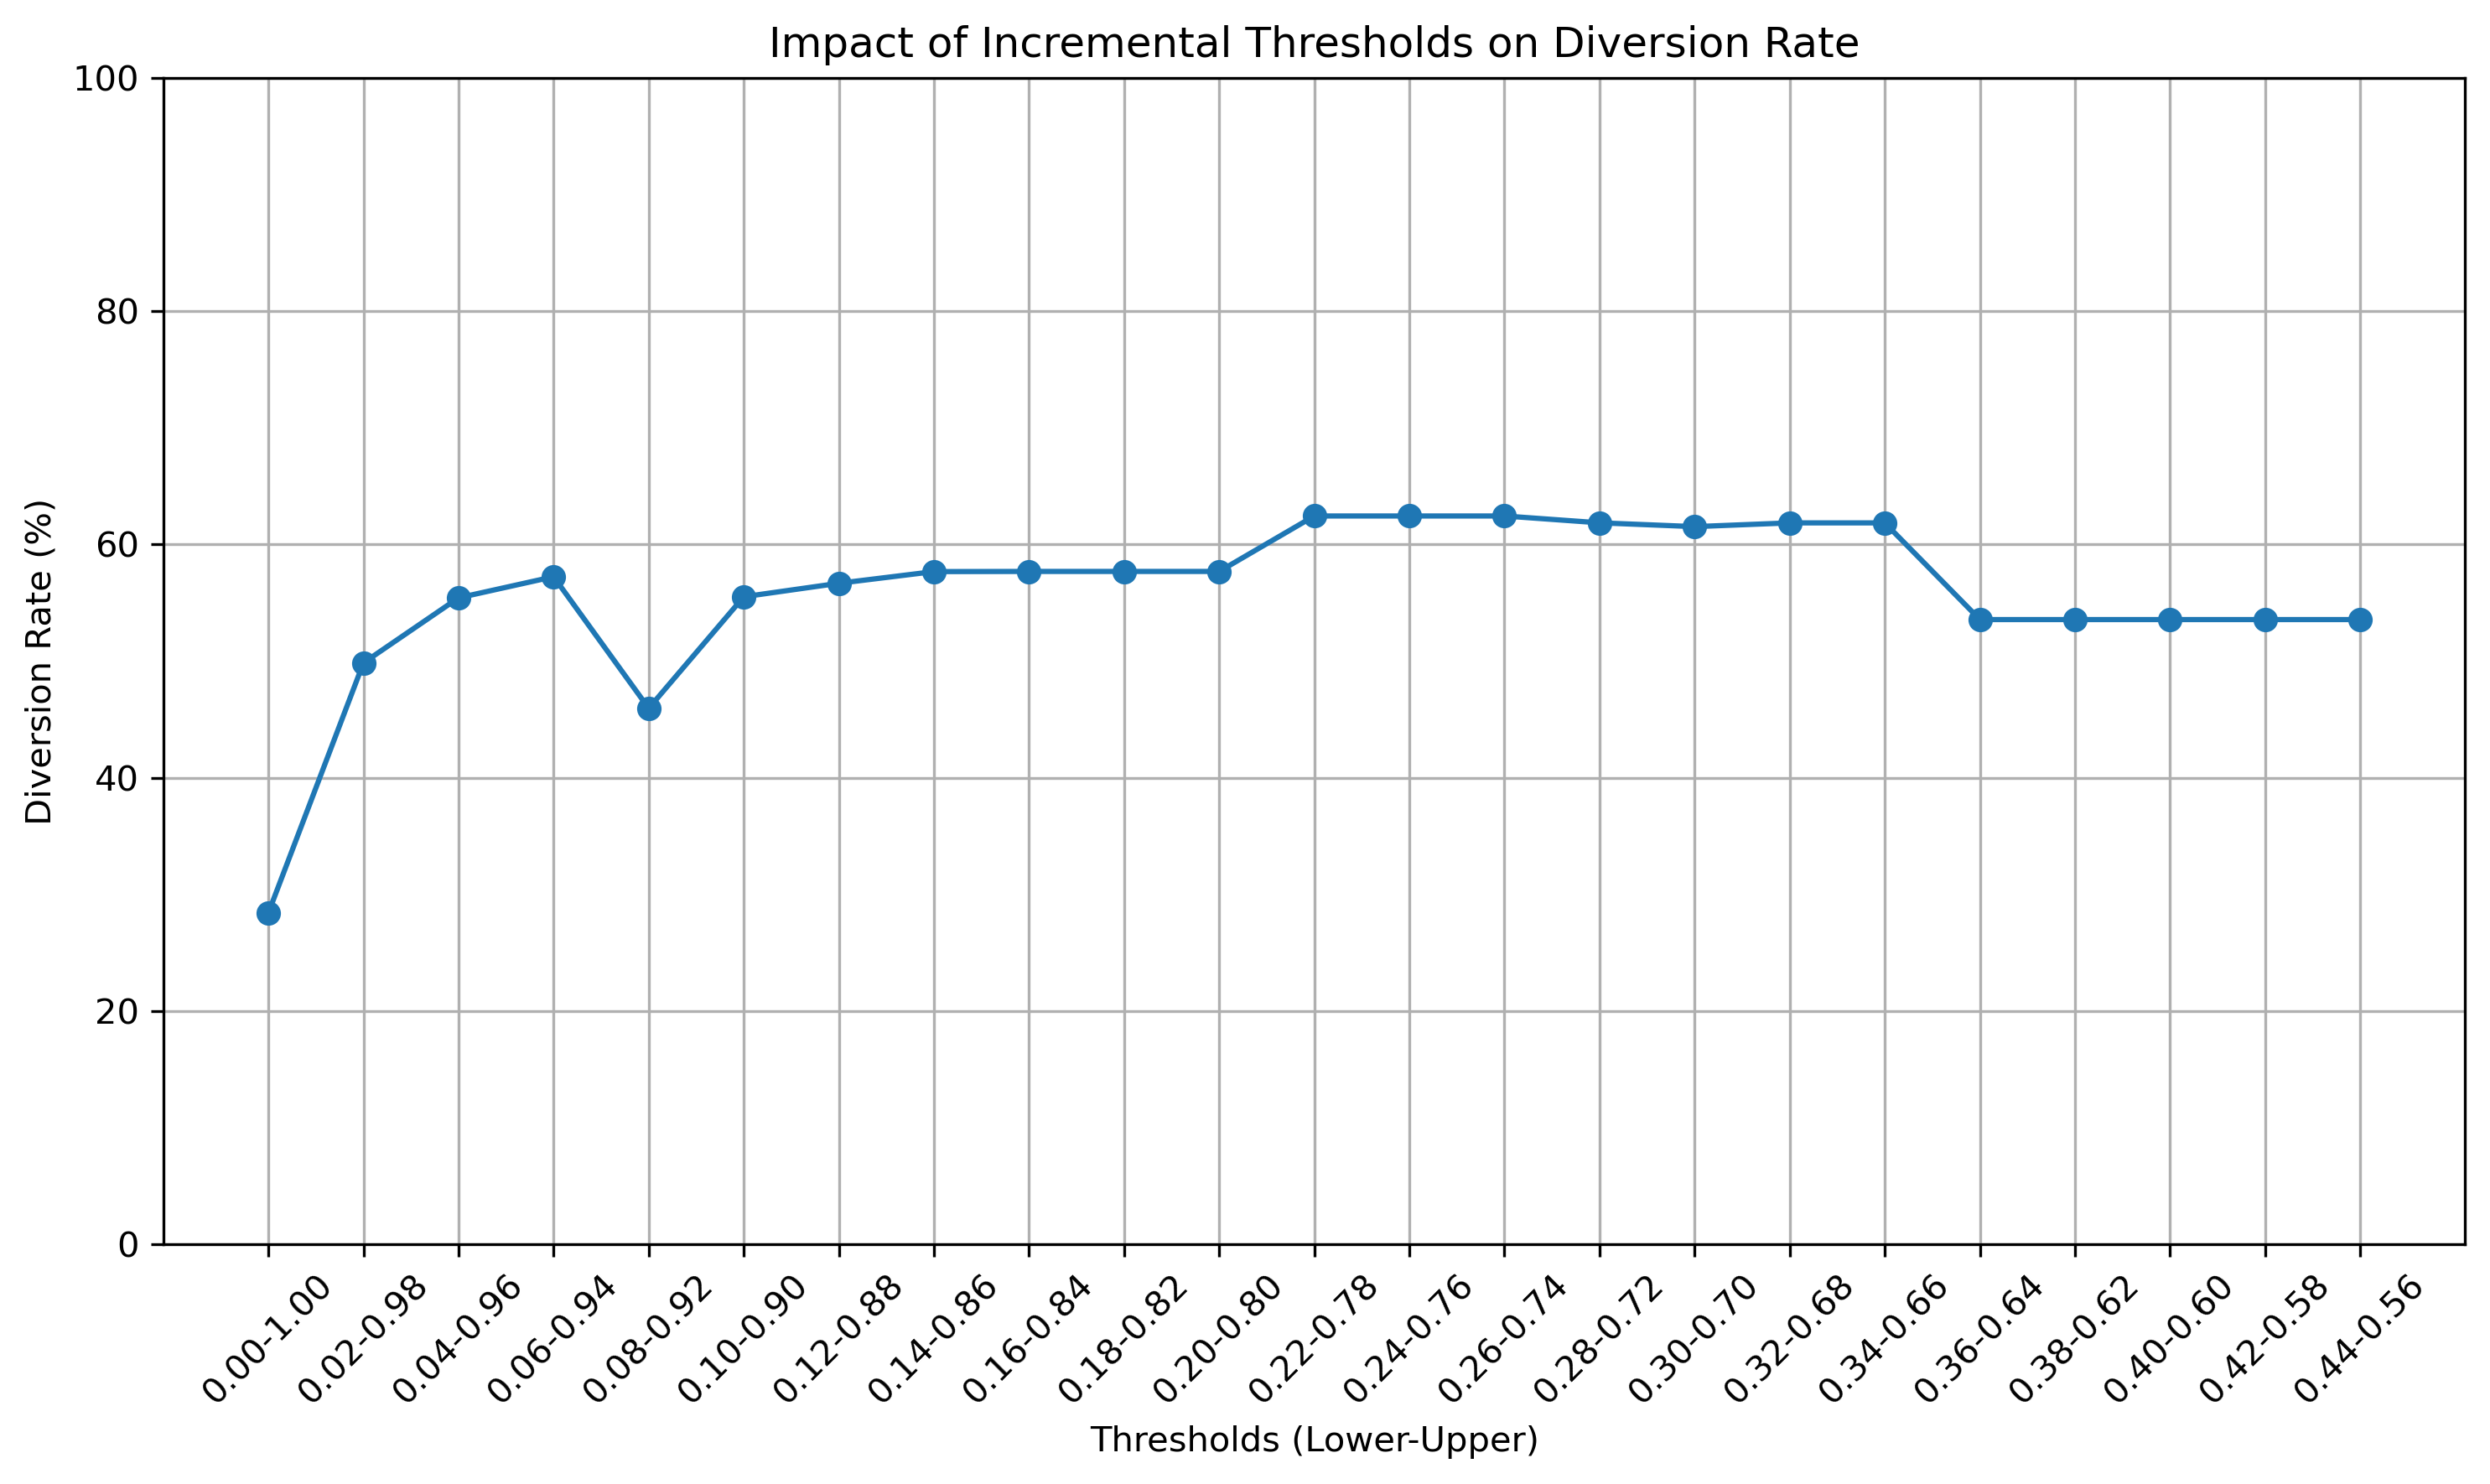

In [154]:
plot_diversion_rate_vs_threshold(dataset_builder(CAD_data, dispatched=True, arrived=True, time=['2017', '2021', 'calltime']),initial_lower=0.0, initial_upper=1.0, step=0.02)

In [155]:
import matplotlib.pyplot as plt
import squarify
import numpy as np
import pandas as pd
import hashlib

In [160]:
def create_treemap_adv(data, title, top_n, group_others, color_list, min_label_area_ratio=0.005):
    num_colors = len(color_list)
    
    # Ensure the 'total' column is correctly computed
    data["total"] = data["cahoots_count"] + data["police_count"]
    
    # Sort data by 'total' in descending order
    sorted_data = data.sort_values(by="total", ascending=False)
    
    # Extract proportions of CAHOOTS involvement
    cahoots_proportions = sorted_data["prop_cahoots"]
    
    # Group others if specified
    if group_others:
        top_categories = sorted_data.iloc[:top_n].copy()
        other_sum = sorted_data.iloc[top_n:]["total"].sum()
        other_cahoots_prop = sorted_data.iloc[top_n:]["prop_cahoots"].mean()  # Mean CAHOOTS proportion for 'Other'
        
        # Create an 'Other' category if needed
        if other_sum > 0:
            other_row = pd.DataFrame({
                'nature': ['Other'],
                'total': [other_sum],
                'prop_cahoots': [other_cahoots_prop]
            })
            top_categories = pd.concat([top_categories, other_row], ignore_index=True)
    
    else:
        top_categories = sorted_data.iloc[:top_n]

    # Assign a color to each category
    color_map = {}
    assigned_colors = set()
    for idx, row in top_categories.iterrows():
        label = row['nature']
        index = hash(label) % num_colors  # Assign a color based on hashing
        original_index = index  
        while color_list[index] in assigned_colors:
            index = (index + 1) % num_colors
            if index == original_index:
                break  
        color_map[label] = color_list[index]
        assigned_colors.add(color_list[index])
    
    # Setup the figure and axes for plotting
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Prepare the data for plotting
    sizes = top_categories["total"].values
    colors = [color_map[label] for label in top_categories["nature"]]
    total_sum = top_categories["total"].sum()
    labels = [f"{incident}\n({value / total_sum * 100:.1f}%)" for incident, value in zip(top_categories["nature"], sizes)]
    
    # Plot the treemap
    squarify.plot(sizes=sizes, label=["" for _ in sizes], color=colors, alpha=0.8, pad=False, ax=ax, ec='black', text_kwargs={'fontsize': 'smaller'})
    plt.title(title)
    plt.axis('off')

    total_area = sum([rect.get_width() * rect.get_height() for rect in ax.patches])
    
    # Add labels and hatches for CAHOOTS proportions
    for text, rect, label in zip(labels, ax.patches, top_categories["nature"]):
        area_ratio = (rect.get_width() * rect.get_height()) / total_area
        if area_ratio > min_label_area_ratio:
            # Create the text object to get its size
            text_obj = ax.text(0, 0, text, fontsize=max(6, min(16, area_ratio * total_area / 100)), ha='center', va='center')
            text_bb = text_obj.get_window_extent(renderer=fig.canvas.get_renderer()).transformed(ax.transData.inverted())

            # Increase padding around the text to make the boxes slightly larger
            padding = 1  # Increase padding for larger boxes
            text_width = text_bb.width + padding
            text_height = text_bb.height + padding

            # Remove the temporary text object (we'll recreate it with proper coordinates)
            text_obj.remove()

            # Draw a solid rectangle behind the label for readability
            text_rect = plt.Rectangle(
                (rect.get_x() + rect.get_width() / 2 - text_width / 2, rect.get_y() + rect.get_height() / 2 - text_height / 2),
                text_width,
                text_height,
                facecolor='white',  # Background color (solid)
                edgecolor='black',
                alpha=1,  # Adjust transparency for better visual
                zorder=2  # Ensure it appears below the text
            )
            ax.add_patch(text_rect)
            
            # Draw the label over the solid background rectangle
            ax.text(rect.get_x() + rect.get_width()/2, rect.get_y() + rect.get_height()/2, text, ha='center', va='center', fontsize=max(6, min(16, area_ratio * total_area / 100)), zorder=3)

        # Overlay CAHOOTS proportion with hatches
        cahoots_prop = top_categories.loc[top_categories["nature"] == label, "prop_cahoots"].values[0]
        cahoots_width = rect.get_width() * cahoots_prop
        hatch_rect = plt.Rectangle(
            (rect.get_x(), rect.get_y()), 
            cahoots_width, 
            rect.get_height(), 
            hatch='xxxx',  # You can replace this with other patterns as desired
            facecolor='none', 
            edgecolor='black', 
            lw=0,
            zorder=1  # Ensure it appears beneath the label
        )
        ax.add_patch(hatch_rect)

    plt.show()

In [161]:
prop_table(CAD_data)

,nature,cahoots_count,police_count,prop_cahoots
2,TRANSPORT,19910,1058,0.949542
0,ASSIST PUBLIC- POLICE,28670,6260,0.820784
5,FOUND SYRINGE,1363,606,0.692230
4,INTOXICATED SUBJECT,2059,1152,0.641233
10,DISORIENTED SUBJECT,526,346,0.603211
...,...,...,...,...
49,THEFT,7,27615,0.000253
99,FRAUD,1,4617,0.000217
80,HIT AND RUN,2,12256,0.000163
105,AUDIBLE ALARM,1,9089,0.000110


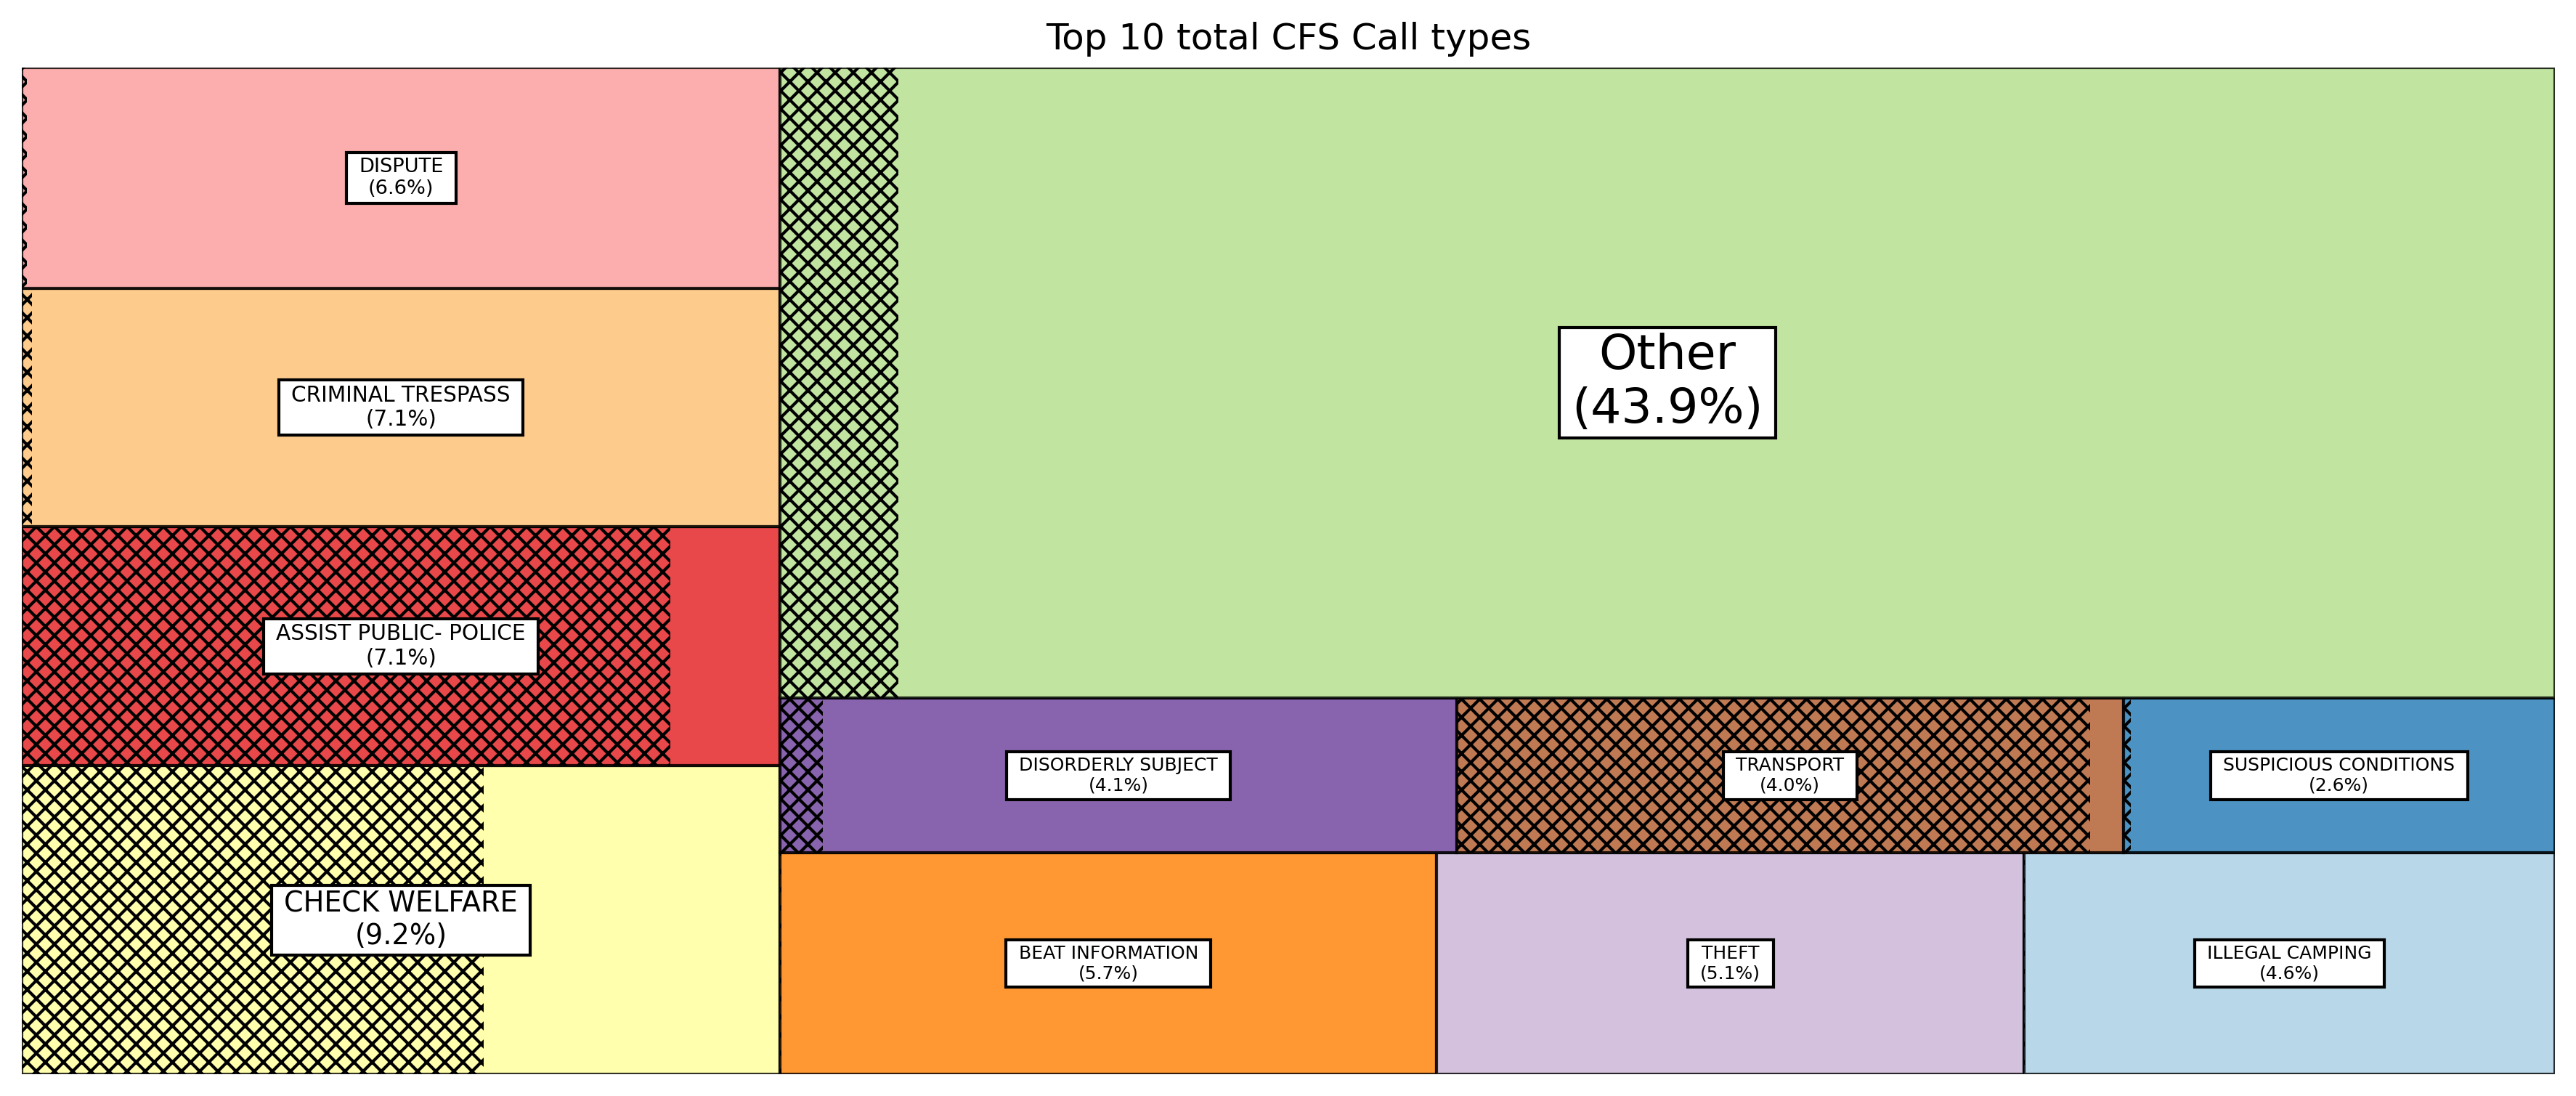

In [175]:
title = "Top 10 total CFS Call types"
top_n = 10
group_others = True


overlap_table = prop_table(CAD_data)
#color_list = plt.cm.Paired.colors
#color_list = plt.get_cmap('tab20').colors

#overlap_table = prop_table(CAD_data)
overlap_table = prop_table(dataset_builder(CAD_data, dispatched=False, arrived=False, time=['2016', '2021', 'calltime']))
color_list = plt.cm.Paired.colors
create_treemap_adv(overlap_table, title=title, top_n=top_n, group_others=group_others, color_list=color_list , min_label_area_ratio=0.005)

# The Natural Experiment  

In [177]:
CAD_data["yr"].value_counts()

yr
2021    88898
2019    86214
2020    83648
2018    79334
2017    79094
2016    76037
2015    67145
2014    61313
2024    27930
Name: count, dtype: int64

In [284]:
CAD_pre_2017 = dataset_builder(CAD_data, dispatched=True, arrived=False, solo_cahoots=False, time=['2014', '2016', 'calltime'])
CAD_2017 = dataset_builder(CAD_data, dispatched=True, arrived=False, solo_cahoots=False, time=['2017', '2017', 'calltime'])

CAD_pre_2017_nat = CAD_pre_2017[(CAD_pre_2017["calltime"].dt.hour >= 5) & (CAD_pre_2017["calltime"].dt.hour < 10)]
CAD_2017_nat = CAD_2017[(CAD_2017["calltime"].dt.hour >= 5) & (CAD_2017["calltime"].dt.hour < 10)]

In [285]:
CAD_pre_2017_nat[CAD_pre_2017_nat["Cahoots_related"] == 1]["yr"].value_counts()

yr
2016    364
2015    151
2014    119
Name: count, dtype: int64

In [286]:
CAD_pre_2017_nat.sort_values(by='yr').head(50)

,yr,calltime,inci_id,parent_id,case_id,callsource,nature,closed_as,disp,arrv,priority,parent_call,primeunit,units_dispd,units_arrived,Cahoots_related
1048104,2014,2014-06-26 08:53:43,14139055,14139055,1410716.0,PHONE,LOCATION STOLEN VEHICLE,REPORT TAKEN,1,1,3,NaN,_3E46,1,1,0
959935,2014,2014-09-20 09:49:44,14215363,14215363,NaN,PHONE,SUSPICIOUS CONDITIONS,ADVISED,1,1,3,NaN,_2E14,2,2,0
959954,2014,2014-09-18 07:58:28,14213325,14213325,NaN,PHONE,BURGLARY,ADVISED,1,1,5,NaN,_2E34,1,1,0
959972,2014,2014-09-16 05:07:58,14211675,14211675,NaN,W911,UNKNOWN PROBLEM,ADVISED,1,1,3,NaN,_5E51,2,2,0
960002,2014,2014-08-24 08:15:39,14191536,14191535,NaN,PHONE,SUBJECT DOWN,ADVISED,1,1,1,"{""inci_id"":""14191535"",""agency"":""MTRO"",""calltim...",_2E21,2,2,0
960006,2014,2014-08-25 08:35:49,14192241,14192241,NaN,PHONE,CHECK WELFARE,ADVISED,1,1,3,NaN,_1E69,2,1,0
595529,2014,2014-12-07 08:39:01,14276805,14276805,1421125.0,PHONE,FOLLOW UP,REPORT TAKEN,1,1,4,NaN,_2E11,1,1,0
595528,2014,2014-12-05 09:41:22,14275227,14275227,1421006.0,PHONE,SUSPICIOUS CONDITIONS,REPORT TAKEN,1,1,3,NaN,_1E44,3,3,0
595511,2014,2014-12-10 09:39:49,14279016,14279016,1421265.0,PHONE,UNAUTHORIZED USE OF VEHICLE,REPORT TAKEN,1,1,4,NaN,_2E12,1,1,0
595506,2014,2014-12-08 06:45:06,14277431,14277431,1421152.0,PHONE,ATTEMPT TO LOCATE,REPORT TAKEN,1,1,3,NaN,_2E11,1,1,0


In [287]:
CAD_pre_2017_nat["hr"] = CAD_pre_2017_nat['calltime'].dt.hour

C:\Users\Nathan Burton\AppData\Local\Temp\ipykernel_4400\4015616116.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CAD_pre_2017_nat["hr"] = CAD_pre_2017_nat['calltime'].dt.hour


In [288]:
CAD_pre_2017_nat[CAD_pre_2017_nat["Cahoots_related"] == 1]["hr"].value_counts()

hr
9    321
8    171
7     95
6     36
5     11
Name: count, dtype: int64

In [289]:
CAD_pre_2017_nat[CAD_pre_2017_nat["hr"] == 5]

,yr,calltime,inci_id,parent_id,case_id,callsource,nature,closed_as,disp,arrv,priority,parent_call,primeunit,units_dispd,units_arrived,Cahoots_related,hr
9775,2016,2016-01-24 05:57:21,16018242,16018242,NaN,PHONE,LOUD PARTY,ADVISED,1,1,5,NaN,_1E43,2,2,0,5
9857,2016,2016-01-15 05:03:53,16010999,16010999,NaN,PHONE,CRIMINAL TRESPASS,ADVISED,1,1,3,NaN,_6E29,3,2,0,5
9938,2016,2016-01-10 05:32:52,16007261,16007261,NaN,PHONE,DISPUTE,ADVISED,1,1,3,NaN,_5E48,2,2,0,5
10267,2015,2015-11-02 05:10:38,15261677,15261677,NaN,E911,SUSPICIOUS SUBJECT,ADVISED,1,1,3,NaN,_6E28,3,2,0,5
10721,2015,2015-11-26 05:55:46,15280195,15280195,NaN,PHONE,CRIMINAL TRESPASS,ADVISED,1,1,3,NaN,_1E57,2,2,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047305,2014,2014-10-11 05:49:22,14233240,14233240,1417543.0,PHONE,UNAUTHORIZED USE OF VEHICLE,REPORT TAKEN,1,1,P,NaN,_6E29,1,1,0,5
1047400,2014,2014-09-16 05:12:04,14211676,14211676,1415767.0,PHONE,WARRANT SERVICE,REPORT TAKEN,1,0,6,NaN,_6X61,1,1,0,5
1047730,2014,2014-04-16 05:21:55,14081562,14081562,1406207.0,PHONE,ATTEMPT TO LOCATE,REPORT TAKEN,1,1,3,NaN,_5E56,2,2,0,5
1047748,2014,2014-04-22 05:15:20,14086133,14086133,1406629.0,PHONE,THEFT FROM VEHICLE,REPORT TAKEN,1,1,3,NaN,_6E26,5,5,0,5


In [295]:
CAD_pre_2017_nat[CAD_pre_2017_nat["Cahoots_related"] == 1]["hr"].value_counts().reset_index().style.hide()

hr,count
9,321
8,171
7,95
6,36
5,11


In [299]:
CAD_pre_2017_nat[(CAD_pre_2017_nat["yr"] == 2016) & (CAD_pre_2017_nat["Cahoots_related"] == 1) ]["hr"].value_counts().reset_index().style.hide()

hr,count
9,165
8,97
7,68
6,26
5,8


In [292]:
CAD_pre_2017_nat[CAD_pre_2017_nat["yr"] == 2016]["nature"].value_counts().head(20)

nature
CRIMINAL TRESPASS              630
CHECK WELFARE                  542
BEAT INFORMATION               381
DISPUTE                        327
DISORDERLY SUBJECT             310
BURGLARY                       284
ILLEGAL CAMPING                272
SUSPICIOUS CONDITIONS          182
UNAUTHORIZED USE OF VEHICLE    165
SUSPICIOUS SUBJECT             150
THEFT                          129
TRAFFIC HAZARD                 124
ASSIST PUBLIC- POLICE          117
MOTOR VEH ACC UNKNOWN INJ      103
HARASSMENT                      95
TRANSPORT                       88
ASSAULT                         74
SUICIDAL SUBJECT                72
DOG AT LARGE                    49
CRIMINAL MISCHIEF               47
Name: count, dtype: int64

In [293]:
CAD_2017_nat["nature"].value_counts().head(15)

nature
CHECK WELFARE                  711
CRIMINAL TRESPASS              622
TRANSPORT                      469
ASSIST PUBLIC- POLICE          404
DISPUTE                        383
BEAT INFORMATION               318
BURGLARY                       285
DISORDERLY SUBJECT             260
ILLEGAL CAMPING                206
SUSPICIOUS SUBJECT             164
SUSPICIOUS CONDITIONS          163
TRAFFIC HAZARD                 155
UNAUTHORIZED USE OF VEHICLE    152
SUICIDAL SUBJECT               113
THEFT                          111
Name: count, dtype: int64

In [23]:
inconsistent_rows = CAD_data[(CAD_data['Call_First_Dispatched_Time'].notna()) & (CAD_data['Unit_Dispatched_Time'].isna())]

# Display the inconsistent rows
print(len(inconsistent_rows))

82


In [24]:
# Standardize Cahoots identifiers 
cahoots_identifiers = r"1J77\s*|3J79\s*|3J78\s*|3J77\s*|4J79\s*|3J81\s*|3J76\s*|2J28\s*|2J29\s*|CAHOOT\s*|CAHOT\s*|CAHO\s*"

CAD_data["PrimaryUnitCallSign"] = CAD_data["PrimaryUnitCallSign"].replace(cahoots_identifiers, 'CAHOOT', regex=True)
CAD_data["RespondingUnitCallSign"] = CAD_data["RespondingUnitCallSign"].replace(cahoots_identifiers, 'CAHOOT', regex=True)

# Create an identifier for Cahoots involvement 
CAD_data['Cahoots_related'] = ((CAD_data['PrimaryUnitCallSign'] == 'CAHOOT') | (CAD_data['RespondingUnitCallSign'] == 'CAHOOT')).astype(int)

# Convert dt
CAD_data["Call_Created_Time"] = pd.to_datetime(CAD_data['Call_Created_Time'], errors='coerce')
CAD_data["year"] = CAD_data["Call_Created_Time"].dt.year

# Drop unneeded cols
#data_cleaned = CAD_data.drop(columns=['Unnamed: 0', 'Beat', 'Call_Zipcode', 'Unit_Cleared_Time', 'Call_Cleared'])
CAD_data = CAD_data.drop(columns=['Unnamed: 0', 'IsPrimary'])

# Only include calls in Eugene 
zip_codes = [97402.0, 97401.0, 97405.0, 97404.0, 97403.0, 97408.0]
CAD_data = CAD_data[CAD_data['Call_Zipcode'].isin(zip_codes)]

# Drop calls with no associated unit
CAD_data = CAD_data.dropna(subset=["PrimaryUnitCallSign", "RespondingUnitCallSign"], how='all')
CAD_data = CAD_data.sort_values(by="Call_Created_Time")

# Drop Exact Duplicates
CAD_data = CAD_data.drop_duplicates()

# Drop non public calls
CAD_data = CAD_data[CAD_data["Call_Source"] != "SELF"]
CAD_data = CAD_data[CAD_data["Call_Source"] != "RPTO"]


#CAD_data

In [25]:
cahoots_data = CAD_data[CAD_data["Cahoots_related"] == 1]
#cahoots_data

In [26]:
def filter_df_by_time(df, start_time=None, end_time=None, time_column='Call_Created_Time'):
    """
    Filters the dataframe based on the time range specified by the user

    Parameters:
    df to filter
    start_time (str)
    end_time (str)
    time_column (str): The name of the column containing datetime values

    """
    df.loc[:, time_column] = pd.to_datetime(df[time_column])

    if start_time:
        if len(start_time) == 4:  # if only a year is given
            start_time = pd.to_datetime(f"{start_time}-01-01")
    else:
        start_time = df[time_column].min() 

    if end_time:
        if len(end_time) == 4:  
            end_time = pd.to_datetime(f"{end_time}-12-31 23:59:59")
    else:
        end_time = df[time_column].max()  

    filtered_df = df[(df[time_column] >= start_time) & (df[time_column] <= end_time)]

    return filtered_df

#filter_df_by_time(cahoots_data, '2021', '2021')

In [27]:
def dataset_builder(data, dispatched=False, arrived=False, cahoots_only=0, time=None):
    """
    Parameters:
    time (list of strings) [start time, end time, time_col]
    
    """
    # Apply time range if specified
    if time:
        data = filter_df_by_time(data, time[0], time[1], time[2])
    
    # Dispatched filter is based on "Unit_Dispatched_Time"
    if dispatched:
        data = data[data["Unit_Dispatched_Time"].notna()]
    
    # Arrived filter is based on "Call_First_Dispatched_Time"
    if arrived:
        data = data[data["Unit_OnScene_Time"].notna()]
        
    return data


#dataset_builder(CAD_data, dispatched=False, arrived=False, time=['2021', '2021', 'Call_Created_Time'])

In [28]:
pd.set_option('display.max_rows', 300)
testdf = dataset_builder(CAD_data, dispatched=True, arrived=True, time=['2021', '2021', 'Call_Created_Time'])

#testdf

In [29]:
#testdf[(testdf["Cahoots_related"] == 1) & (testdf["year"] == 2021)]["InitialIncidentTypeDescription"].value_counts()

In [30]:
#testdf["PrimaryUnitCallSign"].value_counts().head(200)

In [31]:
#testdf["InitialIncidentTypeDescription"].value_counts()

In [32]:
#testdf[testdf["InitialIncidentTypeDescription"] == "PURSUIT"] 

In [33]:
#testdf[testdf["InitialIncidentTypeDescription"] == "DISPUTE"].head(50)

In [34]:
#testdf[testdf["IncidentNumber"].str.contains("21001223")]

In [35]:
#testdf[testdf["InitialIncidentTypeDescription"] == "DISPUTE"]["Cahoots_related"].value_counts()

In [36]:

testdf = CAD_data[~CAD_data["IncidentNumber"].duplicated(keep=False)]
len(testdf)

262799

In [37]:
#testdf[testdf["year"]==2021]

In [38]:
#CAD_data[CAD_data["year"] == 2021]

pd.set_option('display.max_rows', None)
testdf["PrimaryUnitCallSign"].value_counts()

#testdf[testdf["Disposition"] == "FOLLOW UP INVESTIGATION"]

testdf[testdf["Disposition"] == "K893 DEPLOYED"]

In [ ]:
# Useful filter function

incident_df.groupby(['year', 'InitialIncidentTypeDescription']).size().reset_index(name='count').query("InitialIncidentTypeDescription == @key")